In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [2]:
#data
transform = transforms.ToTensor()

trainset = datasets.MNIST(root='./data', train=True,
                          transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False,
                         transform=transform, download=True)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.11MB/s]


In [3]:
#model
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

model = DNN().to(device)


In [4]:
#training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
epochs = 8

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(testloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")


Epoch 1: Train=0.3278, Val=0.1280
Epoch 2: Train=0.1313, Val=0.0851
Epoch 3: Train=0.0936, Val=0.0812
Epoch 4: Train=0.0747, Val=0.0669
Epoch 5: Train=0.0621, Val=0.0623
Epoch 6: Train=0.0535, Val=0.0652
Epoch 7: Train=0.0464, Val=0.0572
Epoch 8: Train=0.0422, Val=0.0658


Test Accuracy: 98.02


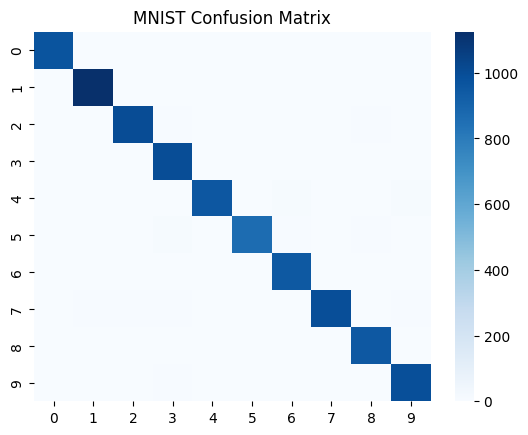

In [5]:
#accuracy and confusion matrix
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        y_true.extend(labels.cpu())
        y_pred.extend(preds.cpu())

print("Test Accuracy:", 100 * correct / total)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues")
plt.title("MNIST Confusion Matrix")
plt.show()



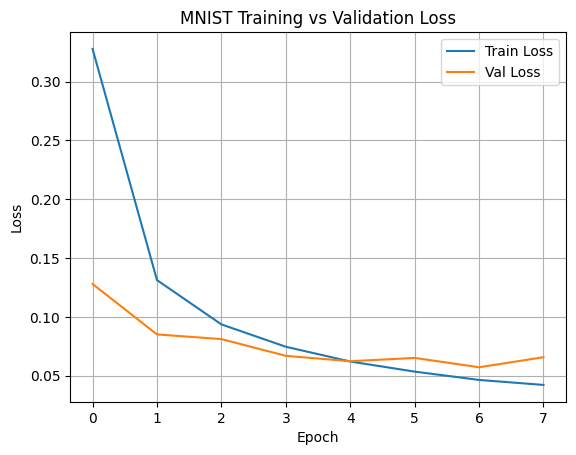

In [6]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("MNIST Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
